In [ ]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

import shap
from windowshap import StationaryWindowSHAP

# Set seeds for reproducibility
np.random.seed(7) # For NumPy
tf.random.set_seed(7) # For TensorFlow

In [100]:
## Step 0 : Setting (hyper)parameters and other variables

# Selecting the tickers and features to be used in the analysis
tickers_list = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
included_features = ['Open', 'Close', 'High', 'Low', 'Volume']

# Start and end dates, as well as window size as in (Chaudhary and Rajneesh, 2025)
sample_start_date = '2024-04-01'
sample_end_date = '2025-05-01'
window_size = 60

In [ ]:
# Stored data


In [101]:
## Step 1 : Fetch and scale stock data using Yahoo Finance

# Download and store stock data (daily)
def get_stock_data(ticker):
    df = yf.download(ticker, start=sample_start_date, end=sample_end_date, group_by='column')
    return df[included_features]

print("Downloading and storing data...")
data_map = {ticker: get_stock_data(ticker) for ticker in tickers_list}

for ticker in tickers_list:
    df = data_map[ticker]

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.columns.name = None
    data_map[ticker] = df


# Normalize each ticker separately
print("Normalizing data...")

scalers = {}
scaled_data_map = {}

for ticker in tickers_list:
    df = data_map[ticker]

    # Define train split index — e.g., 80% of data
    train_size = int(len(df) * 0.8)
    train_df = df.iloc[:train_size]
    scaler = MinMaxScaler()  # or RobustScaler()

    # Fit on train only
    scaler.fit(train_df)

    # Transform full series (using train-fitted scaler)
    scaled_array = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_array, columns=df.columns, index=df.index)

    scaled_data_map[ticker] = scaled_df
    scalers[ticker] = scaler

print("Data prep complete.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Normalizing data...
Data prep complete.


In [ ]:
## Step 2 : Build and train LSTM models

# Build LSTM model

def prep_data(df):
    split_idx = int(len(df) * 0.8) # 80/20 train/test split

    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx - window_size:]
    
    X_train, y_train = build_sequences(train_df, window_size)
    X_test, y_test = build_sequences(test_df, window_size)

    return X_train, y_train, X_test, y_test


def build_model(n_input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=n_input_shape))
    model.add(Dropout(0.2)) 
    model.add(LSTM(32)) 
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse')

    return model

# Build sequences
def build_sequences(df, window_size):
    X, y = [], []
    arr = df.values

    close_idx = df.columns.get_loc('Close')  

    for i in range(len(df) - window_size):
        X.append(arr[i:i + window_size])
        y.append(arr[i + window_size, close_idx])

    return np.array(X), np.array(y)

def gen_store_predictions(model, X_test, y_test, ticker):
    y_pred = model.predict(X_test, verbose=0)
    scaler = scalers[ticker]
    close_idx = data_map[ticker].columns.get_loc('Close')

    dummy_pred = np.zeros((y_pred.shape[0], len(included_features)))
    dummy_pred[:, close_idx] = y_pred.flatten()
    inv_y_pred = scaler.inverse_transform(dummy_pred)[:, close_idx]

    dummy_test = np.zeros((y_test.shape[0], len(included_features)))
    dummy_test[:, close_idx] = y_test.flatten()
    inv_y_test = scaler.inverse_transform(dummy_test)[:, close_idx]

    return inv_y_pred, inv_y_test

def evaluate_predictions(inv_y_pred, inv_y_test):
    mae = np.mean(np.abs(inv_y_pred - inv_y_test))
    mse = mean_squared_error(inv_y_test, inv_y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((inv_y_test - inv_y_pred)/ inv_y_test)) * 100
    return mae, mse, rmse, mape
# Store models and SHAP values
models = {}
X_train_sets = {}
X_test_sets = {}
y_pred_sets = {}
y_test_sets = {}
eval_metrics = {}

for ticker in tickers_list:
    print(f'\nProcessing {ticker} :')
    X_train, y_train, X_test, y_test = prep_data(scaled_data_map[ticker])
    X_train_sets[ticker], X_test_sets[ticker] = X_train, X_test
    
    # Training model
    print('Building and training...')
    model = build_model(n_input_shape=(window_size, X_train.shape[2]))
    model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0)
    models[ticker] = model
    
    # Generate and store predictions
    print('Generating predictions...')
    inv_y_pred, inv_y_test = gen_store_predictions(model, X_test, y_test, ticker)
    y_pred_sets[ticker], y_test_sets[ticker] = inv_y_pred, inv_y_test

    # Evaluation metrics
    print('Evaluating model...')
    mae, mse, rmse, mape = evaluate_predictions(inv_y_pred, inv_y_test)
    eval_metrics[ticker] = {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape
    }

eval_df = pd.DataFrame.from_dict(eval_metrics, orient='index')
eval_df.index.name = 'Ticker'
eval_df = eval_df[['mae', 'mse', 'rmse', 'mape']]

print("\nLSTM Evaluation Metrics Table:\n")
print(eval_df.to_string(float_format='%.4f'))



Processing AAPL :
Building and training...
Generating predictions...
Evaluating model...

Processing GOOGL :
Building and training...
Generating predictions...
Evaluating model...

Processing MSFT :
Building and training...
Generating predictions...
Evaluating model...

Processing AMZN :
Building and training...
Generating predictions...
Evaluating model...

Evaluation Metrics Table:

           mae      mse    rmse   mape
Ticker                                
AAPL    6.6099 114.9498 10.7215 3.2434
GOOGL   4.1325  30.6765  5.5386 2.5698
MSFT   11.5778 213.7597 14.6205 3.0610
AMZN    7.1239  90.0072  9.4872 3.7684


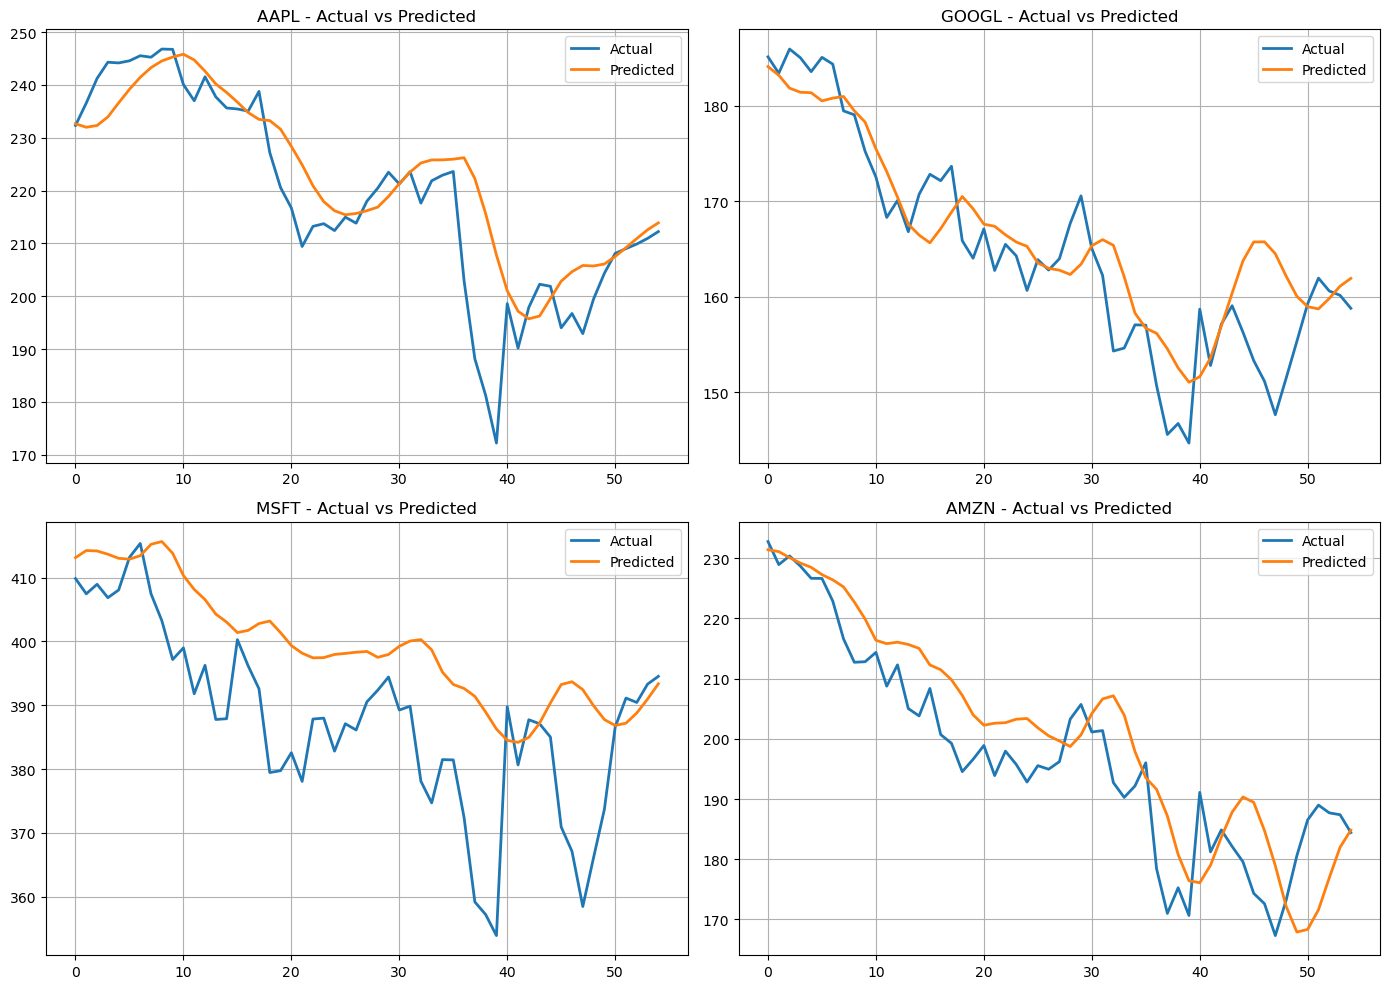

In [103]:
n = len(tickers_list)
cols = 2
rows = (n + 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axs = axs.flatten()

for i, ticker in enumerate(tickers_list):
    axs[i].plot(y_test_sets[ticker], label='Actual', linewidth=2)
    axs[i].plot(y_pred_sets[ticker], label='Predicted', linewidth=2)
    axs[i].set_title(f'{ticker} - Actual vs Predicted')
    axs[i].legend()
    axs[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [133]:
## Step 3 : Compute SHAP values (GradientExplainer)

shap_values_map = {}

def compute_shap(model, X_background, X_test):

    explainer = shap.GradientExplainer(model, X_background)
    shap_values = explainer.shap_values(X_test)
    return shap_values

for ticker in tickers_list:

    model = models[ticker]
    X_train = X_train_sets[ticker]
    X_background = X_train[:100]  # Using first 100 samples for background, might want to be random instead
    X_test = X_test_sets[ticker]

    # Compute SHAP values
    print(f'\nComputing SHAP values for {ticker}...')
    shap_values = compute_shap(model, X_background, X_test) # Only computing for first 10 samples due to slowness of KernelExplainer
    shap_values_map[ticker] = shap_values

print("\nSHAP values computed.")


Computing SHAP values for AAPL...

Computing SHAP values for GOOGL...

Computing SHAP values for MSFT...

Computing SHAP values for AMZN...

SHAP values computed.


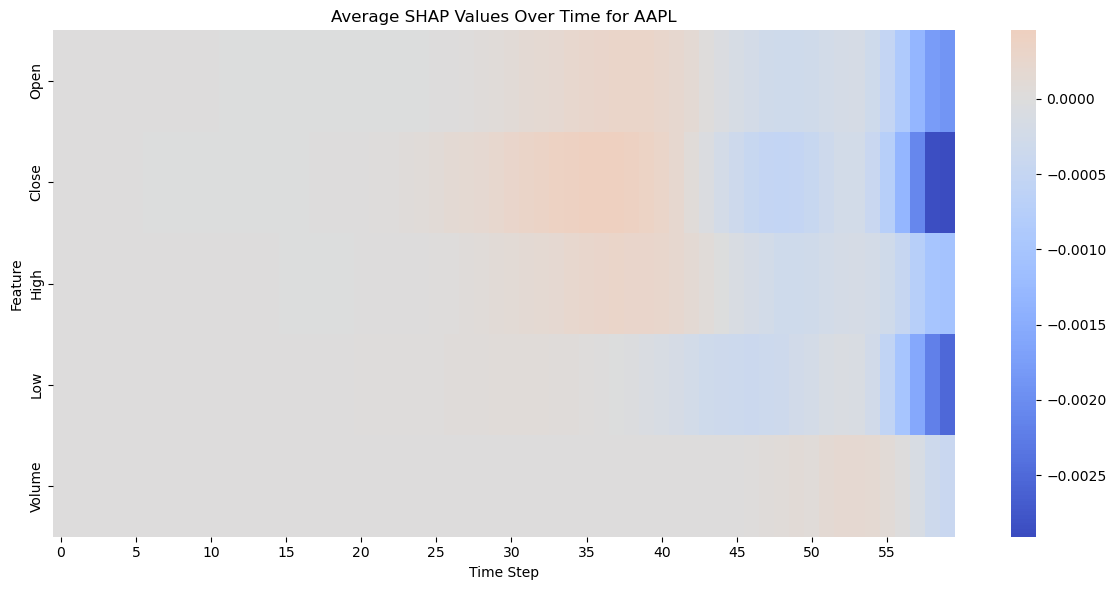

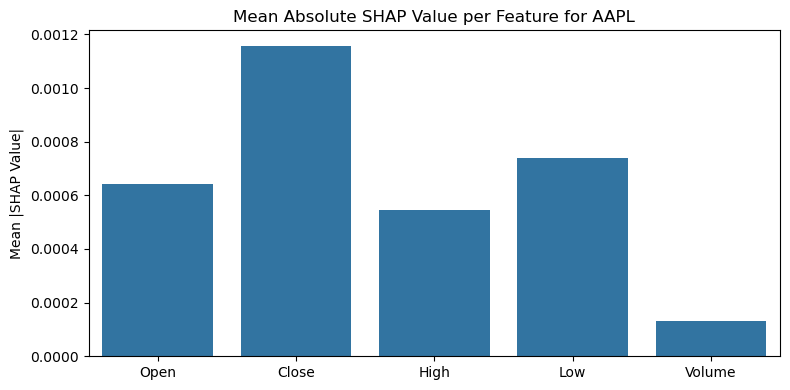

Top 3 features for AAPL: ['Close', 'Low', 'Open']


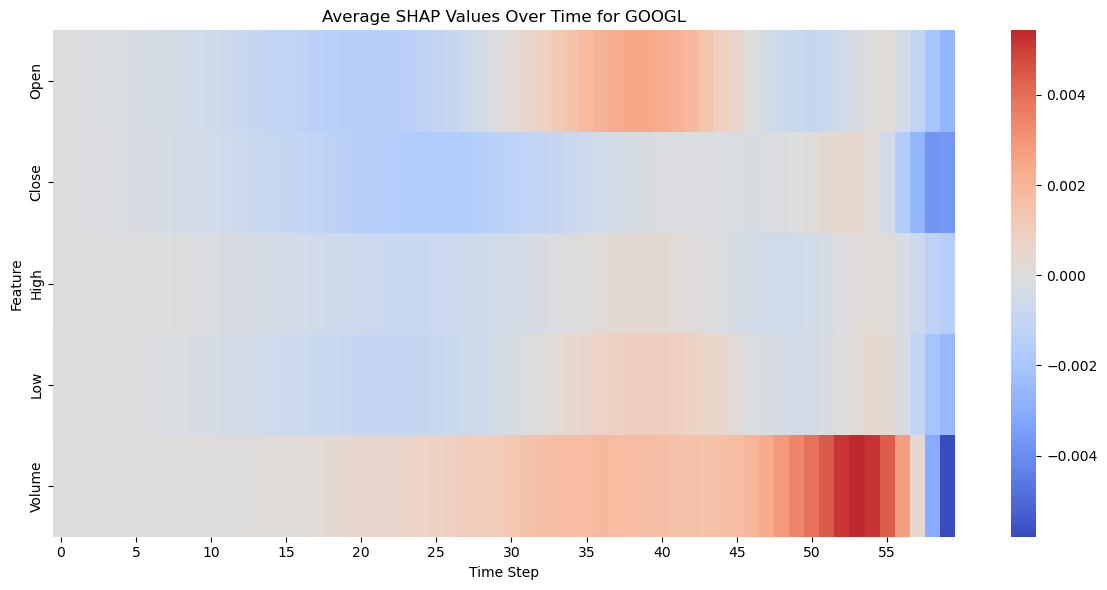

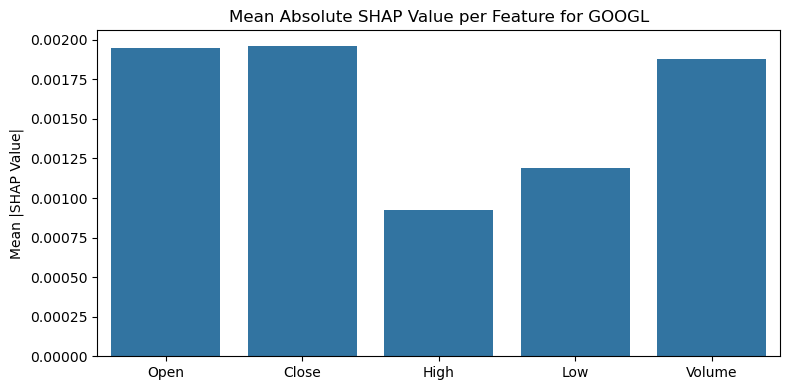

Top 3 features for GOOGL: ['Close', 'Open', 'Volume']


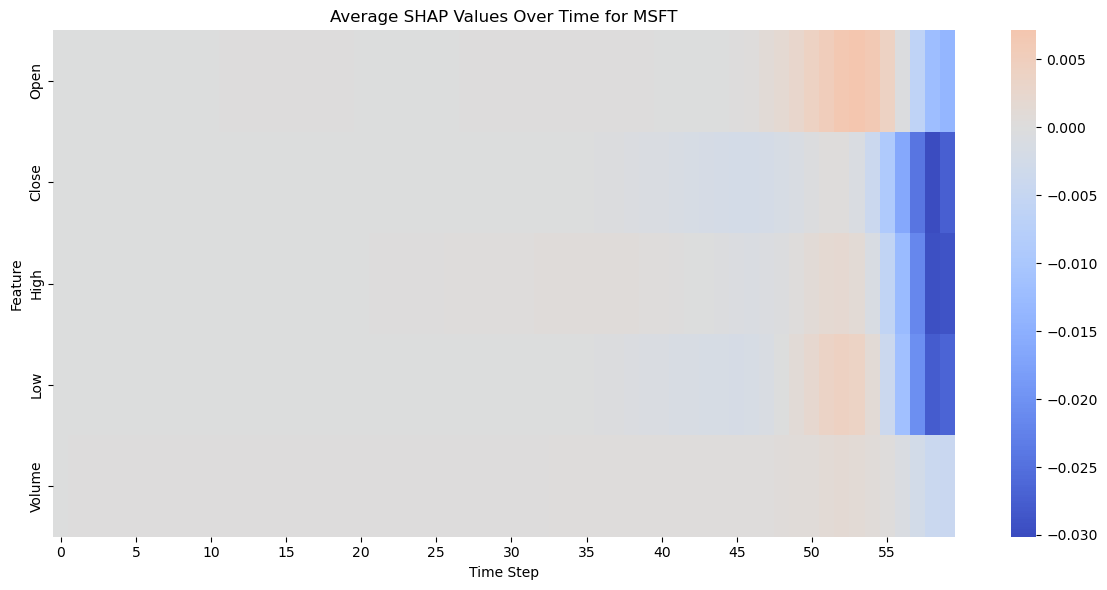

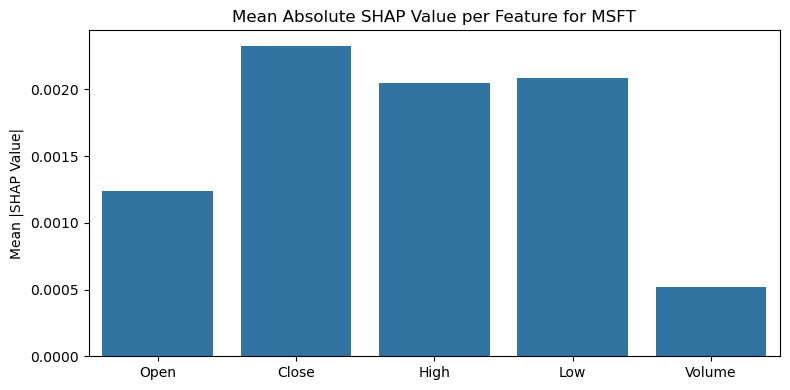

Top 3 features for MSFT: ['Close', 'Low', 'High']


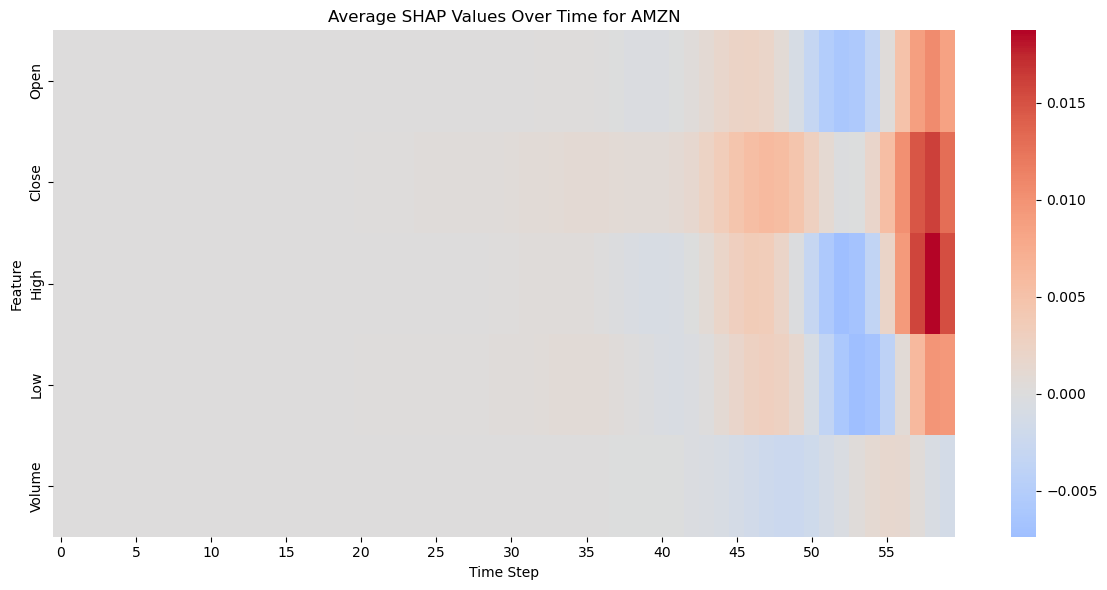

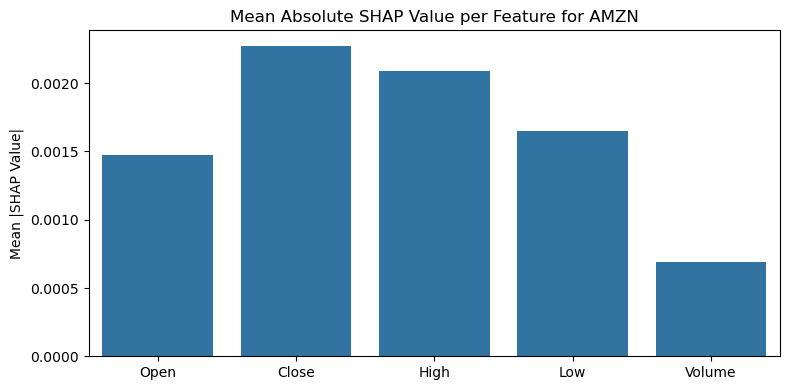

Top 3 features for AMZN: ['Close', 'High', 'Low']


In [ ]:
## Step 5 : Visualize SHAP values
shap.initjs()

SHAP_top3_features_per_ticker = {}

for ticker in tickers_list:

    # Load data
    X_test = X_test_sets[ticker]
    shap_values = shap_values_map[ticker]  # shape: (60, 5, 1)
    avg_shap_values = np.mean(shap_values, axis=0).squeeze(-1)  # shape: (60, 5, 1) -> (60, 5)
    abs_avg_shap_values = np.mean(np.abs(shap_values), axis=(0, 1)).squeeze(-1)  # shape: (5,)

    # --- Heatmap of average SHAP values over time ---
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        avg_shap_values.T,
        xticklabels=5,
        yticklabels=included_features,
        cmap='coolwarm',
        center=0,
        annot=False
    )
    plt.title(f'Average SHAP Values Over Time for {ticker}')
    plt.xlabel('Time Step')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    # --- Bar plot of total average impact per feature ---
    plt.figure(figsize=(8, 4))
    sns.barplot(x=included_features, y=abs_avg_shap_values)
    plt.title(f'Mean Absolute SHAP Value per Feature for {ticker}')
    plt.ylabel('Mean |SHAP Value|')
    plt.tight_layout()
    plt.show()

    # --- Top 3 features based on mean absolute SHAP values ---
    top3_idx = np.argsort(-abs_avg_shap_values)[:3]
    top3_features = [included_features[i] for i in top3_idx]
    SHAP_top3_features_per_ticker[ticker] = top3_features
    print(f'Top 3 features for {ticker}: {top3_features}')


In [ ]:
## Step 4 : Compute WindowSHAP values
window_shap_values_map = {}

def compute_window_shap(model, X_background, X_test, window_size = 60):
    explainer = StationaryWindowSHAP(model, window_len=window_size, B_ts=X_background, test_ts=X_test, model_type='lstm')
    window_shap_values = explainer.shap_values()
    return window_shap_values

for ticker in tickers_list:

    model = models[ticker]
    X_train = X_train_sets[ticker]
    X_background = X_train[:10]  # Using first 10 samples for background, might want to be random instead and 100 instead
    X_test = X_test_sets[ticker]
    ticker_windowSHAP_values = np.zeros((len(X_test), X_test.shape[1], X_test.shape[2]))

    print(f'Computing WindowSHAP values for {ticker}...')
    for i in tqdm(range(len(X_test)), desc=f'Observation {i} of {len(X_test)}'):
        window_shap_values = compute_window_shap(model, X_background, X_test[i:i+1])
        ticker_windowSHAP_values[i,:,:] = window_shap_values

    window_shap_values_map[ticker] = ticker_windowSHAP_values

print("\nWindowSHAP values computed.")

Computing WindowSHAP values for AAPL...


Observation 13 of 55: 100%|██████████| 55/55 [11:32<00:00, 12.60s/it]


Computing WindowSHAP values for GOOGL...


Observation 54 of 55: 100%|██████████| 55/55 [10:50<00:00, 11.83s/it]


Computing WindowSHAP values for MSFT...


Observation 54 of 55: 100%|██████████| 55/55 [10:53<00:00, 11.88s/it]


Computing WindowSHAP values for AMZN...


Observation 54 of 55: 100%|██████████| 55/55 [11:44<00:00, 12.82s/it]


WindowSHAP values computed.


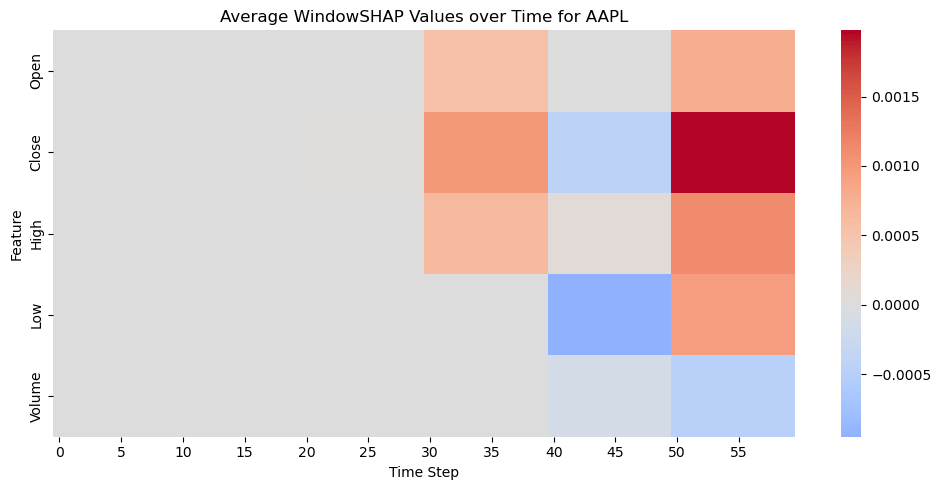

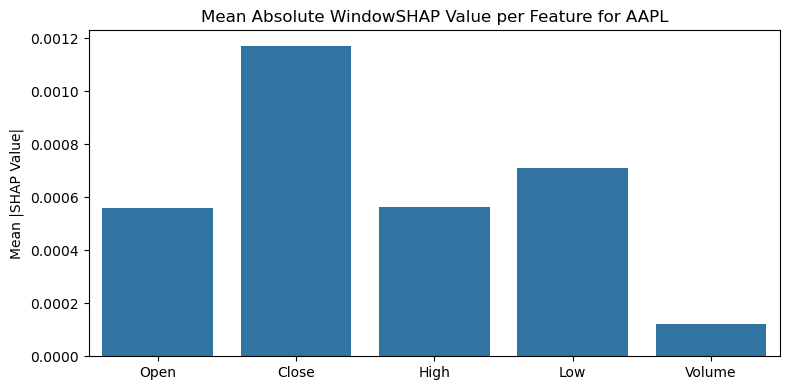

Top 3 features for AAPL: ['Close', 'Low', 'High']


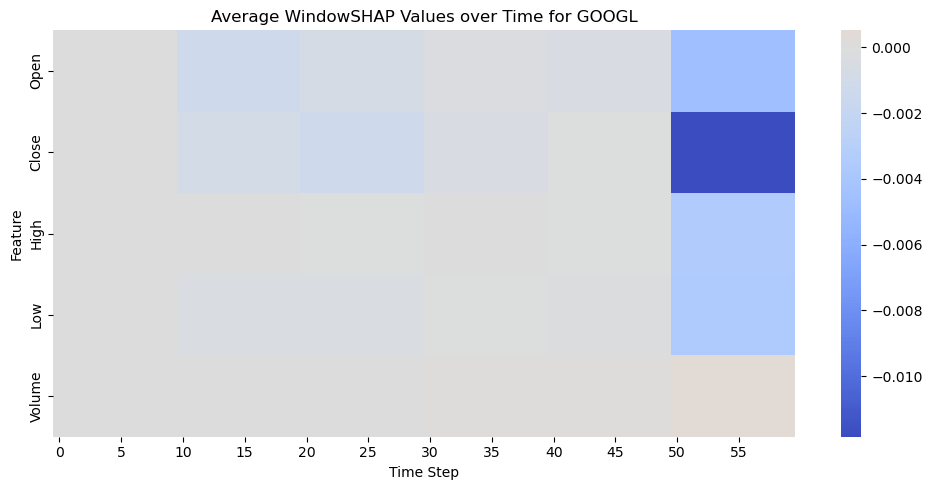

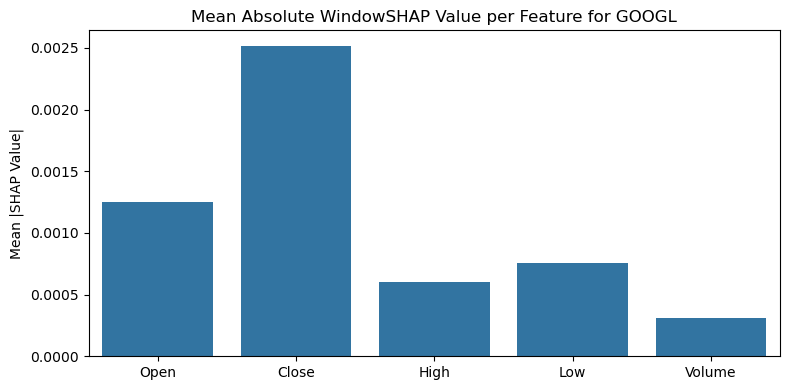

Top 3 features for GOOGL: ['Close', 'Open', 'Low']


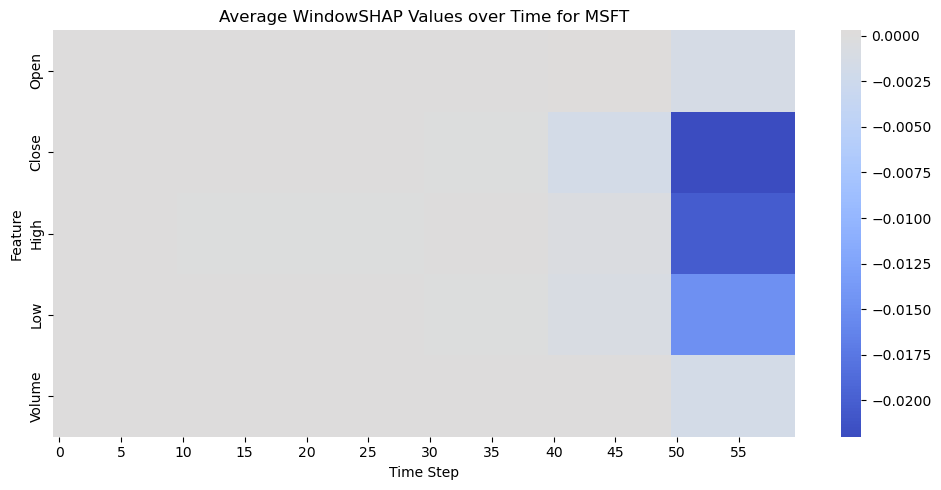

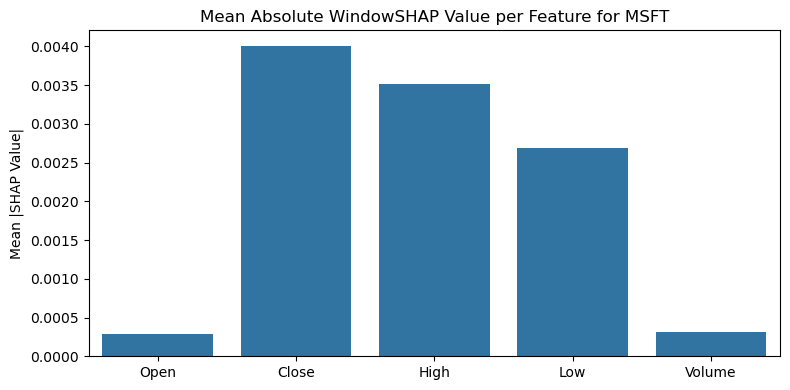

Top 3 features for MSFT: ['Close', 'High', 'Low']


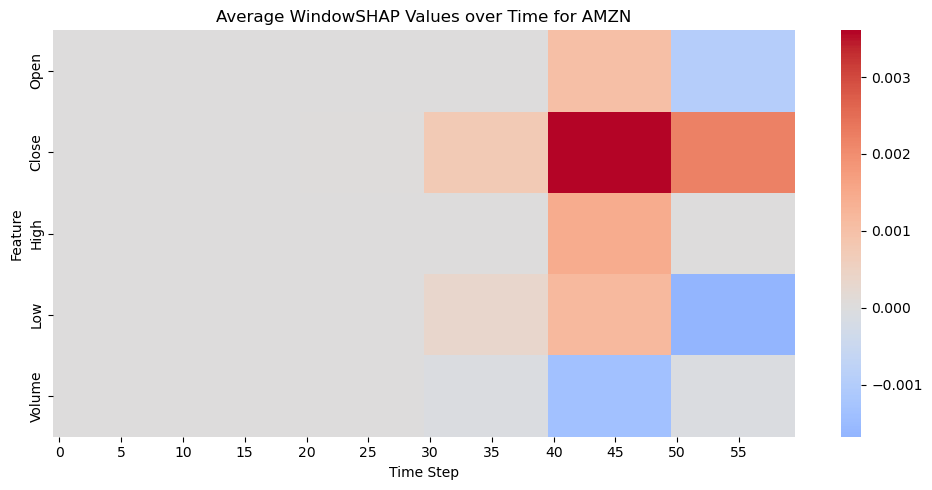

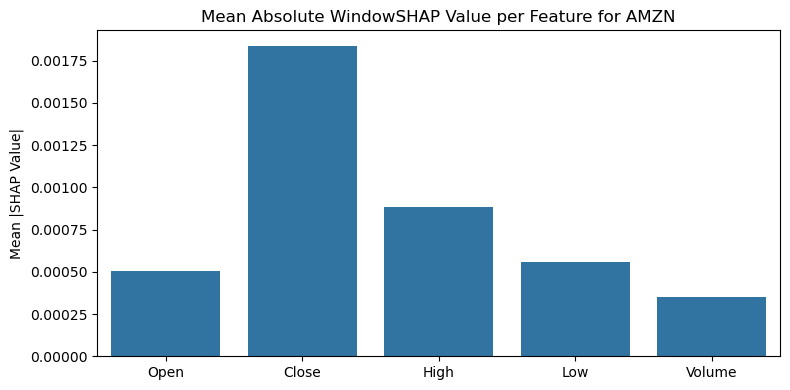

Top 3 features for AMZN: ['Close', 'High', 'Low']


In [149]:
## Step 6 : Visualize WindowSHAP values
shap.initjs()

WindowSHAP_top3_features_per_ticker = {}

for ticker in tickers_list:

    # Load data
    X_test = X_test_sets[ticker]
    window_shap_values = window_shap_values_map[ticker]
    avg_window_shap_values = np.mean(window_shap_values, axis=0)
    abs_avg_window_shap_values = np.mean(np.abs(window_shap_values), axis=(0, 1))

    # --- Heatmap of Average WindowSHAP over Time ---
    plt.figure(figsize=(10, 5))
    sns.heatmap(
        avg_window_shap_values.T,
        xticklabels=5,
        yticklabels=included_features,
        cmap='coolwarm',
        center=0,
        annot=False
    )
    plt.title(f'Average WindowSHAP Values over Time for {ticker}')
    plt.xlabel('Time Step')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    # --- Bar Plot of Average WindowSHAP over Time ---
    plt.figure(figsize=(8, 4))
    sns.barplot(x=included_features, y=abs_avg_window_shap_values)
    plt.title(f'Mean Absolute WindowSHAP Value per Feature for {ticker}')
    plt.ylabel('Mean |SHAP Value|')
    plt.tight_layout()
    plt.show()

    # --- Top 3 features based on mean absolute WindowSHAP values ---
    top3_idx = np.argsort(-abs_avg_window_shap_values)[:3]
    top3_features = [included_features[i] for i in top3_idx]
    WindowSHAP_top3_features_per_ticker[ticker] = top3_features
    print(f'Top 3 features for {ticker}: {top3_features}')


In [146]:
# Step 7 : Compute feature-based WindowSHAP

trend_window_shap_values_map = {}
season_window_shap_values_map = {}
resid_window_shap_values_map = {}

def decompose_series(ts, period=24):
    result = seasonal_decompose(ts, model='additive', period=period, extrapolate_trend='freq')
    trend = result.trend
    seasonal = result.seasonal
    resid = result.resid
    return trend, seasonal, resid

def decompose_dataset(X, period=24):
    n_samples, n_timesteps, n_features = X.shape
    trend_data = np.zeros_like(X)
    seasonal_data = np.zeros_like(X)
    resid_data = np.zeros_like(X)

    for i in range(n_samples):
        for j in range(n_features):
            ts = pd.Series(X[i, :, j])
            trend, seasonal, resid = decompose_series(ts, period)
            trend_data[i, :, j] = trend
            seasonal_data[i, :, j] = seasonal
            resid_data[i, :, j] = resid
    
    return trend_data, seasonal_data, resid_data

for ticker in tickers_list:

    model = models[ticker]
    X_train = X_train_sets[ticker]
    X_background = X_train[:10]
    X_test = X_test_sets[ticker]

    # Decompose train and test data
    trend_train, seasonal_train, resid_train = decompose_dataset(X_train)
    trend_background, seasonal_background, resid_background = decompose_dataset(X_background)
    trend_test, seasonal_test, resid_test = decompose_dataset(X_test)

    # Compute WindowSHAP for trend
    print(f"Computing WindowSHAP for trend component of {ticker}...")
    trend_window_shap_values = np.zeros((len(trend_test), trend_test.shape[1], trend_test.shape[2]))
    for i in tqdm(range(len(trend_test)), desc=f'WindowSHAP - Trend - {ticker}'):
        shap_vals = compute_window_shap(model, trend_background, trend_test[i:i+1])
        trend_window_shap_values[i, :, :] = shap_vals

    # Compute WindowSHAP for seasonal
    print(f"Computing WindowSHAP for seasonal component of {ticker}...")
    seasonal_window_shap_values = np.zeros((len(seasonal_test), seasonal_test.shape[1], seasonal_test.shape[2]))
    for i in tqdm(range(len(seasonal_test)), desc=f'WindowSHAP - Seasonal - {ticker}'):
        shap_vals = compute_window_shap(model, seasonal_background, seasonal_test[i:i+1], window_size=window_size)
        seasonal_window_shap_values[i, :, :] = shap_vals

    # Compute WindowSHAP for residual
    print(f"Computing WindowSHAP for residual component of {ticker}...")
    resid_window_shap_values = np.zeros((len(resid_test), resid_test.shape[1], resid_test.shape[2]))
    for i in tqdm(range(len(resid_test)), desc=f'WindowSHAP - Residual - {ticker}'):
        shap_vals = compute_window_shap(model, resid_background, resid_test[i:i+1], window_size=window_size)
        resid_window_shap_values[i, :, :] = shap_vals

    # Store results in your dictionary
    trend_window_shap_values_map[ticker] = trend_window_shap_values
    season_window_shap_values_map[ticker] = seasonal_window_shap_values
    resid_window_shap_values_map[ticker] = resid_window_shap_values

print("\nDecomposed WindowSHAP values computed.")

Computing WindowSHAP for trend component of AAPL...


WindowSHAP - Trend - AAPL: 100%|██████████| 55/55 [11:13<00:00, 12.25s/it]


Computing WindowSHAP for seasonal component of AAPL...


WindowSHAP - Seasonal - AAPL: 100%|██████████| 55/55 [00:14<00:00,  3.80it/s]


Computing WindowSHAP for residual component of AAPL...


WindowSHAP - Residual - AAPL: 100%|██████████| 55/55 [00:15<00:00,  3.64it/s]


Computing WindowSHAP for trend component of GOOGL...


WindowSHAP - Trend - GOOGL: 100%|██████████| 55/55 [11:20<00:00, 12.37s/it]


Computing WindowSHAP for seasonal component of GOOGL...


WindowSHAP - Seasonal - GOOGL: 100%|██████████| 55/55 [00:17<00:00,  3.10it/s]


Computing WindowSHAP for residual component of GOOGL...


WindowSHAP - Residual - GOOGL: 100%|██████████| 55/55 [00:15<00:00,  3.61it/s]


Computing WindowSHAP for trend component of MSFT...


WindowSHAP - Trend - MSFT: 100%|██████████| 55/55 [12:56<00:00, 14.12s/it]


Computing WindowSHAP for seasonal component of MSFT...


WindowSHAP - Seasonal - MSFT: 100%|██████████| 55/55 [00:17<00:00,  3.14it/s]


Computing WindowSHAP for residual component of MSFT...


WindowSHAP - Residual - MSFT: 100%|██████████| 55/55 [00:16<00:00,  3.25it/s]


Computing WindowSHAP for trend component of AMZN...


WindowSHAP - Trend - AMZN: 100%|██████████| 55/55 [11:49<00:00, 12.90s/it]


Computing WindowSHAP for seasonal component of AMZN...


WindowSHAP - Seasonal - AMZN: 100%|██████████| 55/55 [00:14<00:00,  3.80it/s]


Computing WindowSHAP for residual component of AMZN...


WindowSHAP - Residual - AMZN: 100%|██████████| 55/55 [00:14<00:00,  3.82it/s]


Decomposed WindowSHAP values computed.


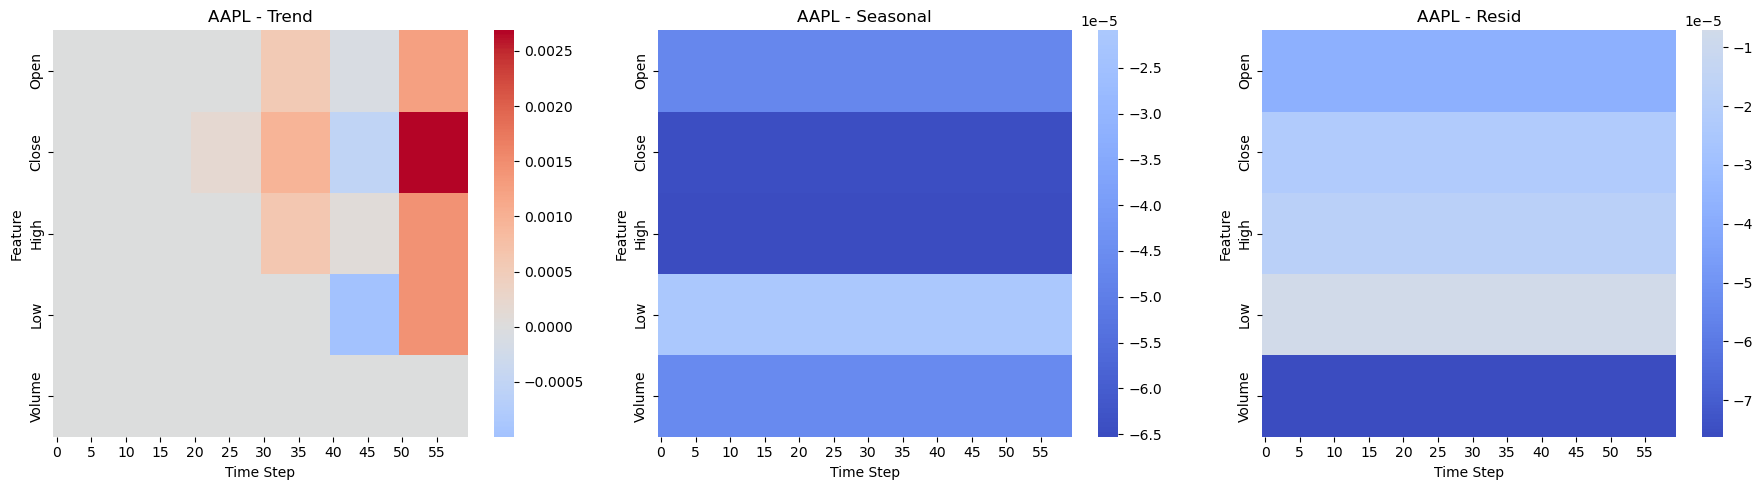

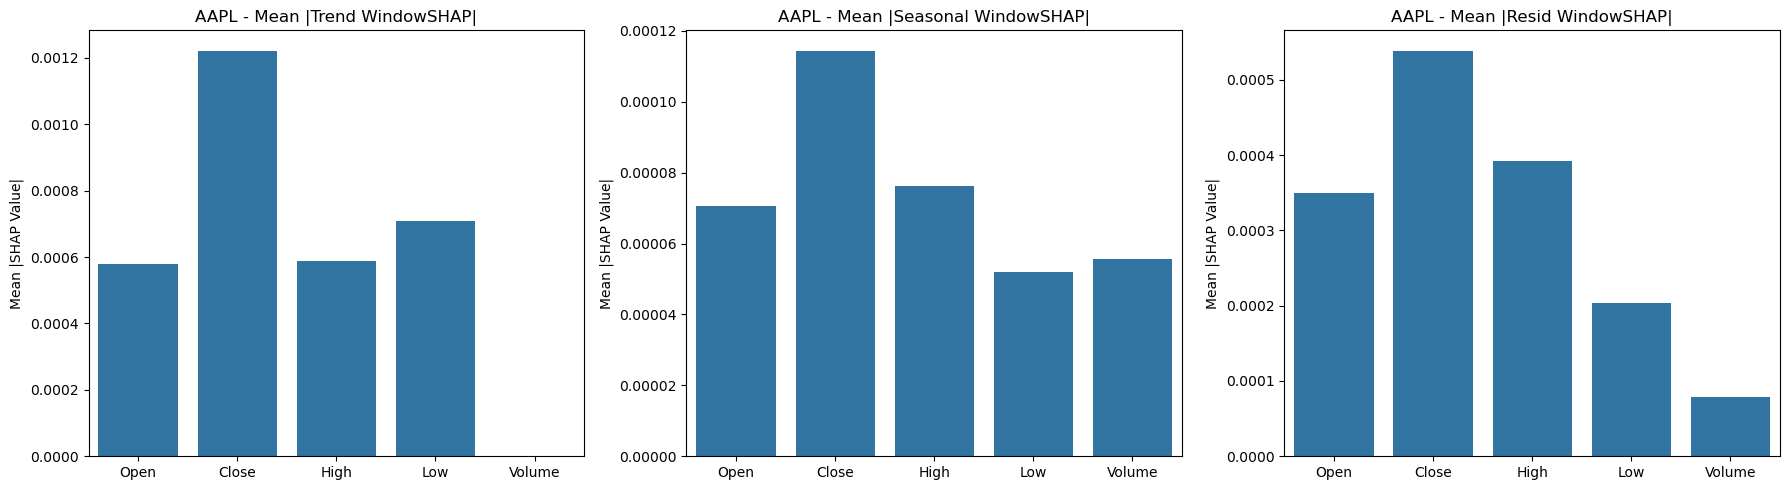

Top 3 (decomposed) features for AAPL: ['trend_Close', 'trend_Low', 'trend_High']


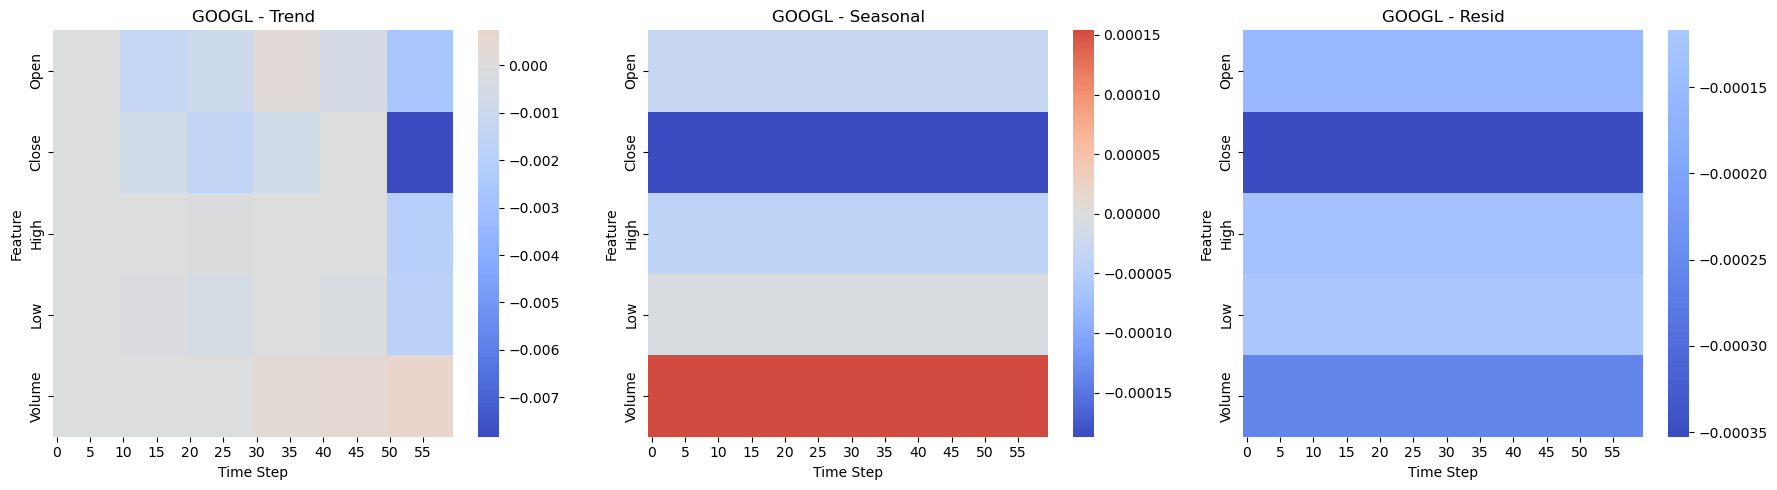

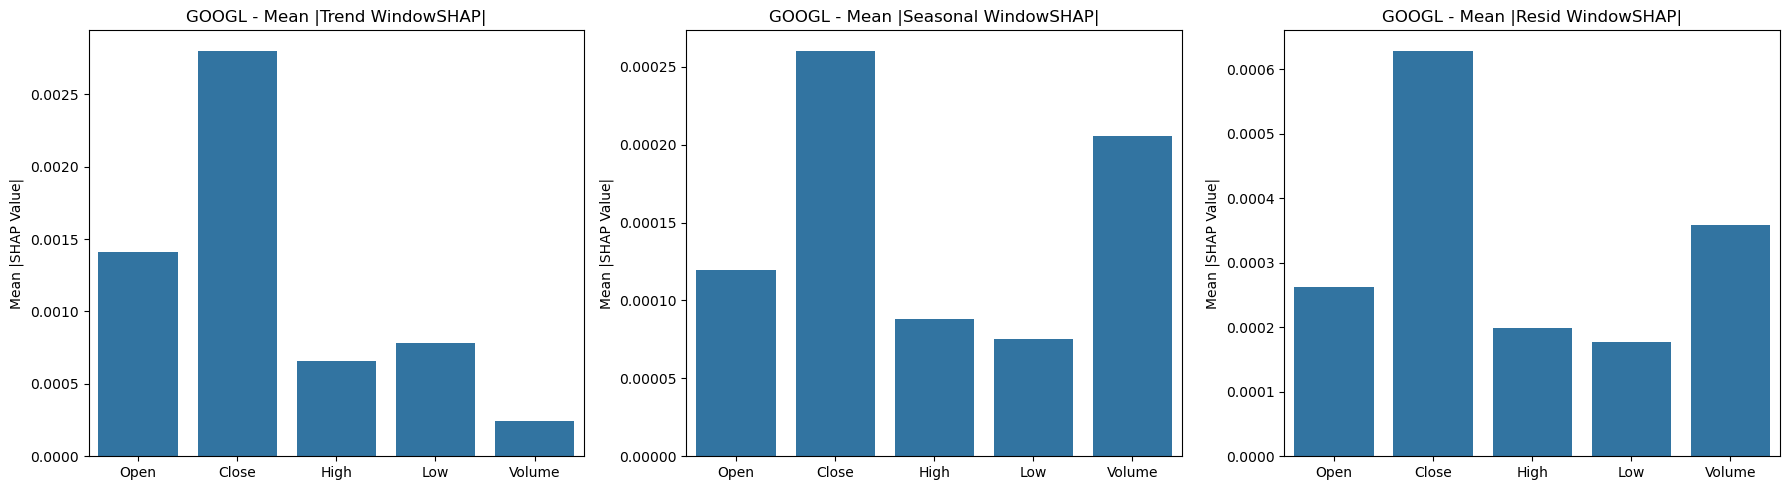

Top 3 (decomposed) features for GOOGL: ['trend_Close', 'trend_Open', 'trend_Low']


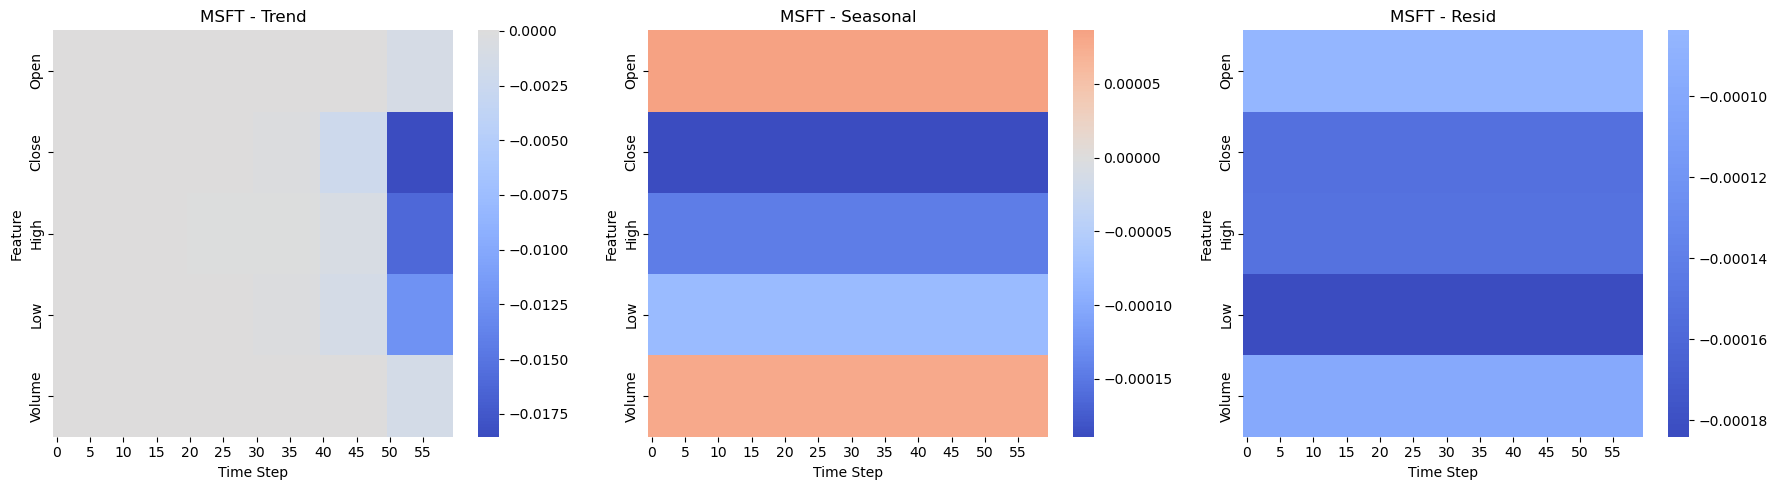

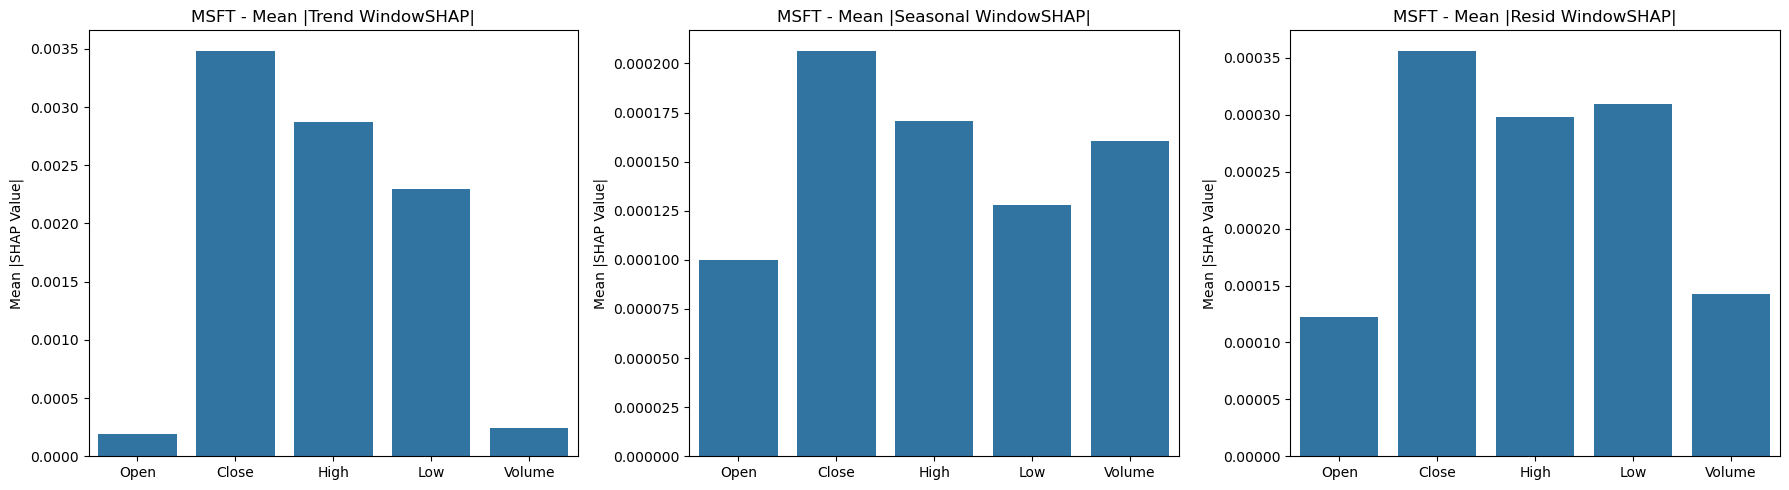

Top 3 (decomposed) features for MSFT: ['trend_Close', 'trend_High', 'trend_Low']


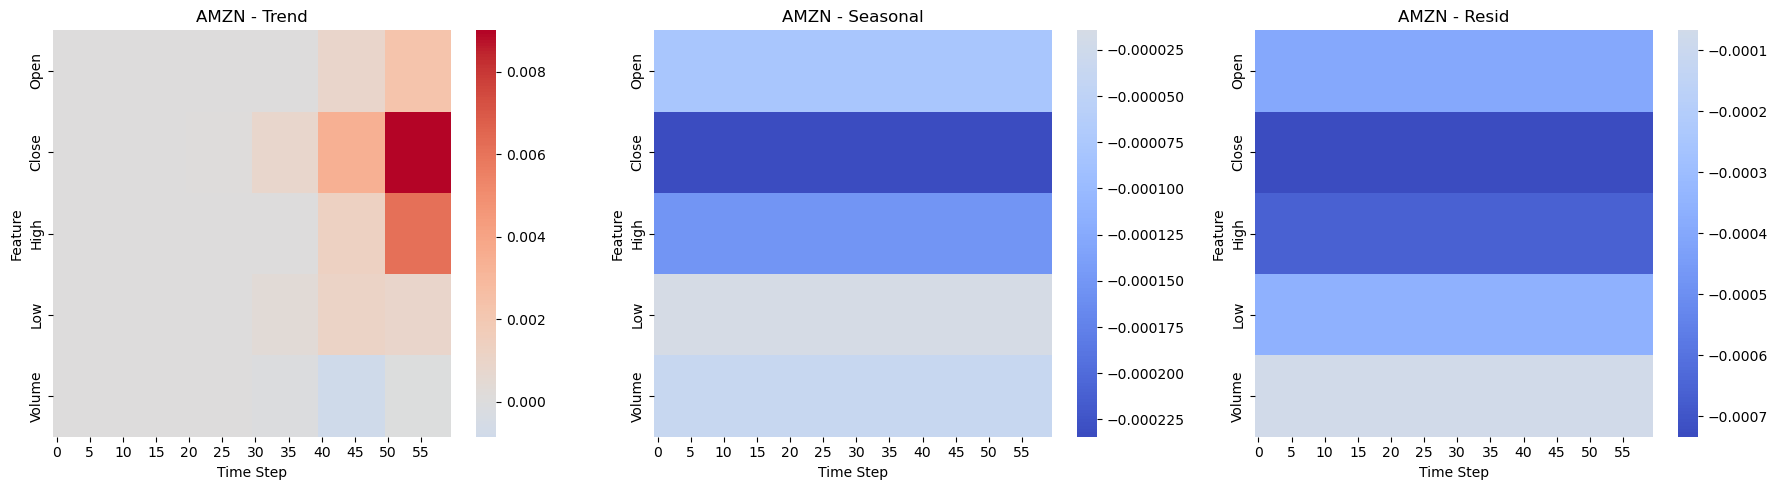

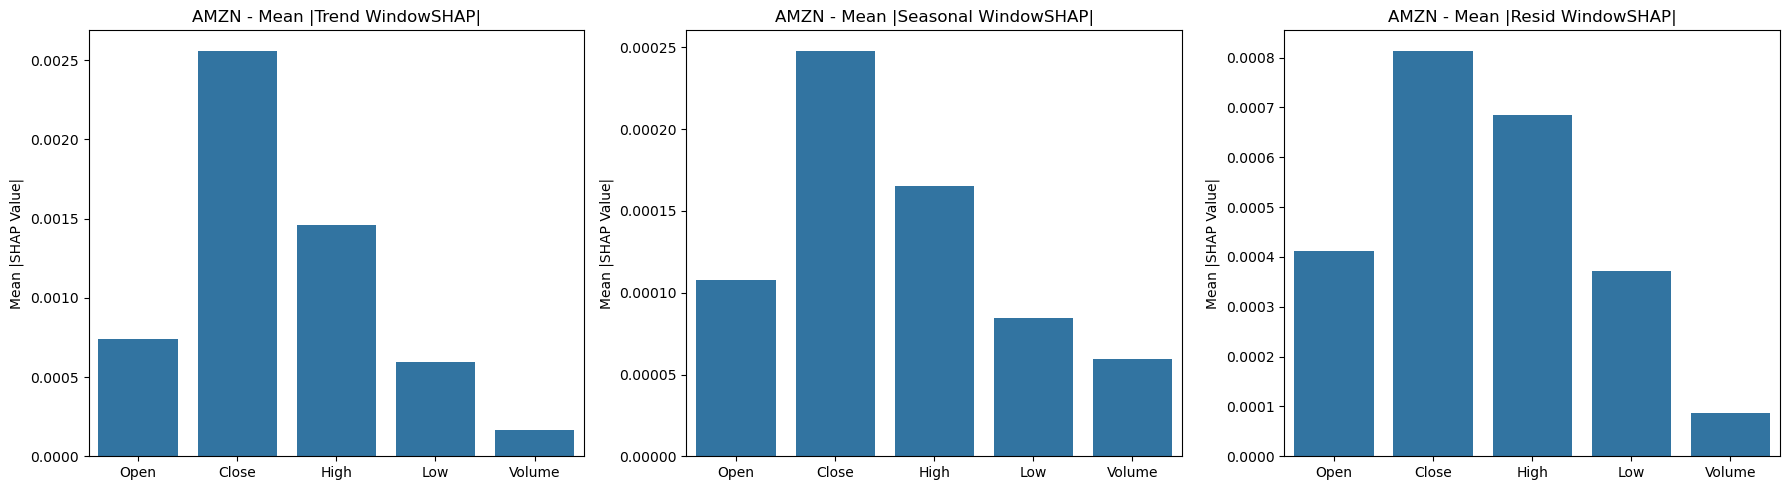

Top 3 (decomposed) features for AMZN: ['trend_Close', 'trend_High', 'resid_Close']


In [159]:
## Step 8 : Visualize decomposed WindowSHAP values

shap.initjs()

Decomposed_WindowSHAP_top3_features_per_ticker = {}
shap_maps = {
    'trend': trend_window_shap_values_map,
    'seasonal': season_window_shap_values_map,
    'resid': resid_window_shap_values_map
}

for ticker in tickers_list:

    avg_shap_values = {}
    abs_avg_shap = {}

    # Load data
    for comp, comp_map in shap_maps.items():
        comp_shap = comp_map[ticker]  # shape: (samples, timesteps, features)
        avg_shap_values[comp] = np.mean(comp_shap, axis=0)  # (timesteps, features)
        abs_avg_shap[comp] = np.mean(np.abs(comp_shap), axis=(0, 1))  # (features,)

    # --- Heatmap of Average Decomposed WindowSHAP over Time ---
    fig, axes = plt.subplots(1, len(shap_maps), figsize=(18, 5))
    for ax, (comp, arr) in zip(axes, avg_shap_values.items()):
        sns.heatmap(
            arr.T, cmap='coolwarm', center=0,
            yticklabels=included_features, xticklabels=5, ax=ax
        )
        ax.set_title(f"{ticker} - {comp.capitalize()}")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # --- Bar Plot of Average Decomposed WindowSHAP over Time ---
    fig, axes = plt.subplots(1, len(shap_maps), figsize=(18, 5))
    for ax, (comp, arr) in zip(axes, abs_avg_shap.items()):
        sns.barplot(x=included_features, y=arr, ax=ax)
        ax.set_title(f"{ticker} - Mean |{comp.capitalize()} WindowSHAP|")
        ax.set_ylabel("Mean |SHAP Value|")
    plt.tight_layout()
    plt.show()

    # --- Top 3 features based on mean absolute WindowSHAP values ---
    combined = []
    for comp, scores in abs_avg_shap.items():
        for idx, score in enumerate(scores):
            combined.append((score, comp, included_features[idx]))

    combined.sort(key=lambda x: x[0], reverse=True)
    top3 = combined[:3]
    Decomposed_WindowSHAP_top3_features_per_ticker[ticker] = [
        f"{comp}_{feat}" for _, comp, feat in top3
    ]

    print(f"Top 3 (decomposed) features for {ticker}:", Decomposed_WindowSHAP_top3_features_per_ticker[ticker])


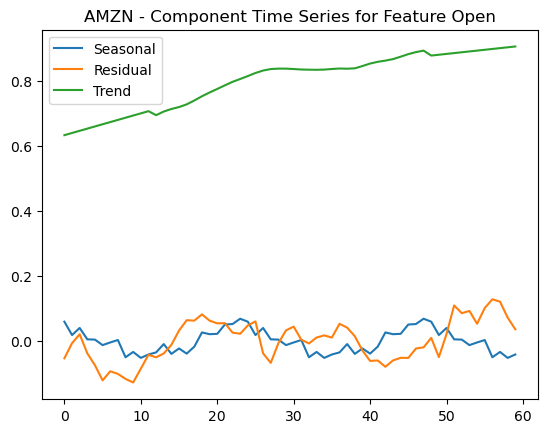

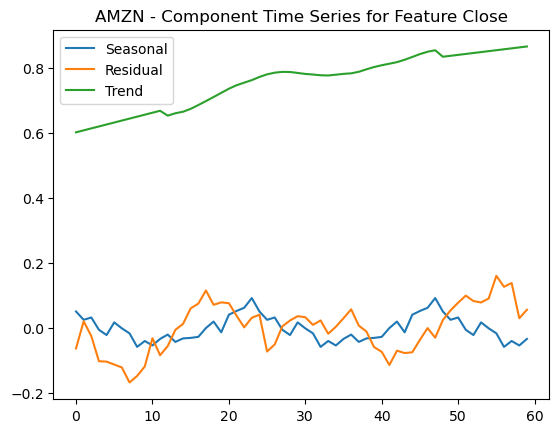

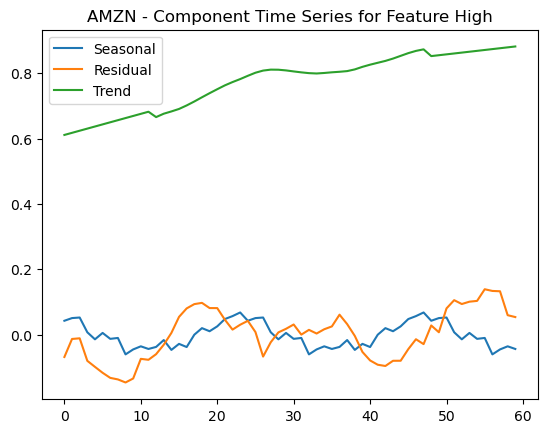

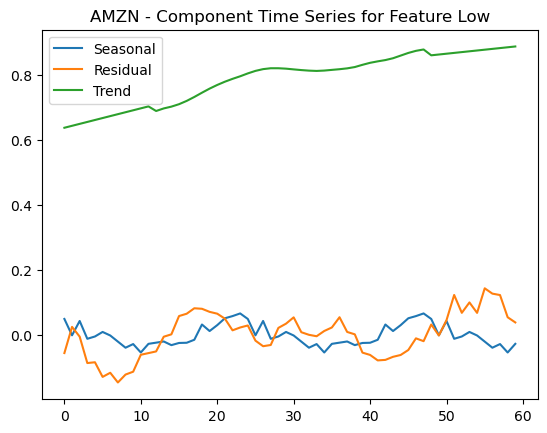

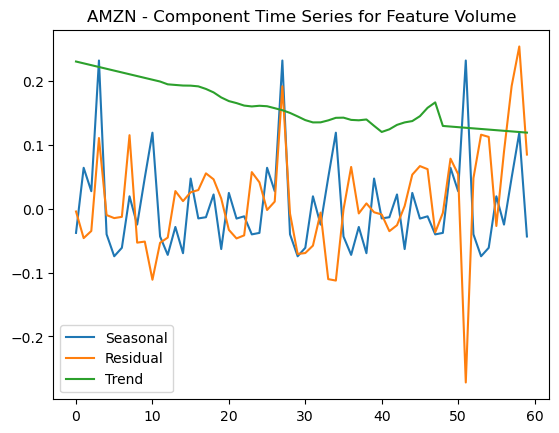

In [158]:
sample_i = 0

for feature in range(len(included_features)):
    plt.plot(seasonal_test[sample_i, :, feature], label='Seasonal')
    plt.plot(resid_test[sample_i, :, feature], label='Residual')
    plt.plot(trend_test[sample_i, :, feature], label='Trend')
    plt.legend()
    plt.title(f"{ticker} - Component Time Series for Feature {included_features[feature]}")
    plt.show()

In [161]:
## Step 9 : Re-run LSTM with decomposed features

SHAP_measures = ('SHAP', 'WindowSHAP', 'Decomposed_WindowSHAP')
top3_features_map = {
    'SHAP': SHAP_top3_features_per_ticker,
    'WindowSHAP': WindowSHAP_top3_features_per_ticker,
    'Decomposed_Wind'
    'owSHAP': Decomposed_WindowSHAP_top3_features_per_ticker
}
eval_metrics_per_measure = {}

for measure in SHAP_measures:

    eval_metrics_per_ticker = {}
    for ticker in tickers_list:
        print(f'\nProcessing {ticker} :')
        top3_features = top3_features_map[measure][ticker]
        df = scaled_data_map[ticker][top3_features]
        X_train, y_train, X_test, y_test = prep_data(df)
        X_train_sets[ticker], X_test_sets[ticker] = X_train, X_test
        
        # Training model
        print('Building and training...')
        model = build_model(n_input_shape=(window_size, X_train.shape[2]))
        model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0)
        models[ticker] = model
        
        # Generate and store predictions
        print('Generating predictions...')
        inv_y_pred, inv_y_test = gen_store_predictions(model, X_test, y_test, ticker)
        y_pred_sets[ticker], y_test_sets[ticker] = inv_y_pred, inv_y_test

        # Evaluation metrics
        print('Evaluating model...')
        mae, mse, rmse, mape = evaluate_predictions(inv_y_pred, inv_y_test)
        eval_metrics_per_ticker[ticker] = {
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'mape': mape
        }

    eval_df = pd.DataFrame.from_dict(eval_metrics, orient='index')
    eval_df.index.name = 'Ticker'
    eval_df = eval_df[['mae', 'mse', 'rmse', 'mape']]

    eval_metrics_per_measure[measure] = eval_df

    print("\nEvaluation Metrics Table:\n")
    print(eval_df.to_string(float_format='%.4f'))





Processing AAPL :
Building and training...
Generating predictions...
Evaluating model...

Processing GOOGL :
Building and training...
Generating predictions...
Evaluating model...

Processing MSFT :
Building and training...
Generating predictions...
Evaluating model...

Processing AMZN :
Building and training...
Generating predictions...
Evaluating model...

Evaluation Metrics Table:

           mae      mse    rmse   mape
Ticker                                
AAPL    6.6099 114.9498 10.7215 3.2434
GOOGL   4.1325  30.6765  5.5386 2.5698
MSFT   11.5778 213.7597 14.6205 3.0610
AMZN    7.1239  90.0072  9.4872 3.7684

Processing AAPL :
Building and training...
Generating predictions...
Evaluating model...

Processing GOOGL :
Building and training...
Generating predictions...
Evaluating model...

Processing MSFT :
Building and training...
Generating predictions...
Evaluating model...

Processing AMZN :
Building and training...
Generating predictions...
Evaluating model...

Evaluation Metr

KeyError: "None of [Index(['trend_Close', 'trend_Low', 'trend_High'], dtype='object')] are in the [columns]"

In [ ]:
from numpy import percentile

def eval_perturbation(model, X_test, y_pred, y_test, percentiles, shap_values, is_windowshap=True, mask_value=0):
    num_samples, num_timesteps, num_features = X_test.shape
    losses = []

    og_loss = np.mean((y_pred - y_test)**2)

    for p in percentiles:
        perturbed_X = X_test.copy()

        for i in range(num_samples):
            if is_windowshap:
                # SHAP shape: (timesteps, features)
                shap_importance = np.abs(shap_values[i]).sum(axis=1)
                top_timesteps = np.argsort(shap_importance)[-int(num_timesteps * p / 100):]
                perturbed_X[i, top_timesteps, :] = mask_value

            else:
                # SHAP shape: (features,)
                shap_importance = np.abs(shap_values[i])
                top_features = np.argsort(shap_importance)[-int(num_features * p / 100):]
                perturbed_X[i, :, top_features] = mask_value  # <-- this must modify X_test

        # Ensure prediction changes after masking
        perturbed_pred = model.predict(perturbed_X, verbose=0)
        perturbed_loss = np.mean((perturbed_pred - y_test)**2)
        percent_change = (perturbed_loss - og_loss) / og_loss * 100
        losses.append(percent_change)

    return np.array(losses)


percentiles = np.arange(60, 91)
methods = ['SHAP', 'WindowSHAP', 'Decomposed WindowSHAP']
shap_results = {}
window_shap_results = {}
decomp_shap_results = {}

N = min(
    X_test.shape[0],
    shap_values_map[ticker].shape[0],
    window_shap_values_map[ticker].shape[0],
    trend_window_shap_values_map[ticker].shape[0],
    season_window_shap_values_map[ticker].shape[0],
    resid_window_shap_values_map[ticker].shape[0]
)


for ticker in tickers_list:
    print(f"\nEvaluating perturbation for {ticker}...")
    model = models[ticker]
    X_test = X_test_sets[ticker]
    y_pred = y_pred_sets[ticker]
    y_test = y_test_sets[ticker]

    # Use consistent slices
    X_test_sub = X_test[:N]
    y_pred_sub = y_pred[:N]
    y_test_sub = y_test[:N]

    # SHAP
    shap_values = np.squeeze(shap_values_map[ticker], axis=-1)[:N]
    shap_results[ticker] = eval_perturbation(model, X_test_sub, y_pred_sub, y_test_sub, percentiles, shap_values, is_windowshap=True)

    # WindowSHAP
    window_shap_values = window_shap_values_map[ticker][:N]
    window_shap_results[ticker] = eval_perturbation(model, X_test_sub, y_pred_sub, y_test_sub, percentiles, window_shap_values, is_windowshap=True)

    # Decomposed WindowSHAP
    trend_shap = trend_window_shap_values_map[ticker][:N]
    seasonal_shap = season_window_shap_values_map[ticker][:N]
    resid_shap = resid_window_shap_values_map[ticker][:N]
    decomp_shap_results[ticker] = {
        'trend': eval_perturbation(model, X_test_sub, y_pred_sub, y_test_sub, percentiles, trend_shap, is_windowshap=True),
        'seasonal': eval_perturbation(model, X_test_sub, y_pred_sub, y_test_sub, percentiles, seasonal_shap, is_windowshap=True),
        'resid': eval_perturbation(model, X_test_sub, y_pred_sub, y_test_sub, percentiles, resid_shap, is_windowshap=True)
    }

    
    


Evaluating perturbation for AAPL...

Evaluating perturbation for GOOGL...

Evaluating perturbation for MSFT...

Evaluating perturbation for AMZN...


Plotting perturbation analysis for AAPL...


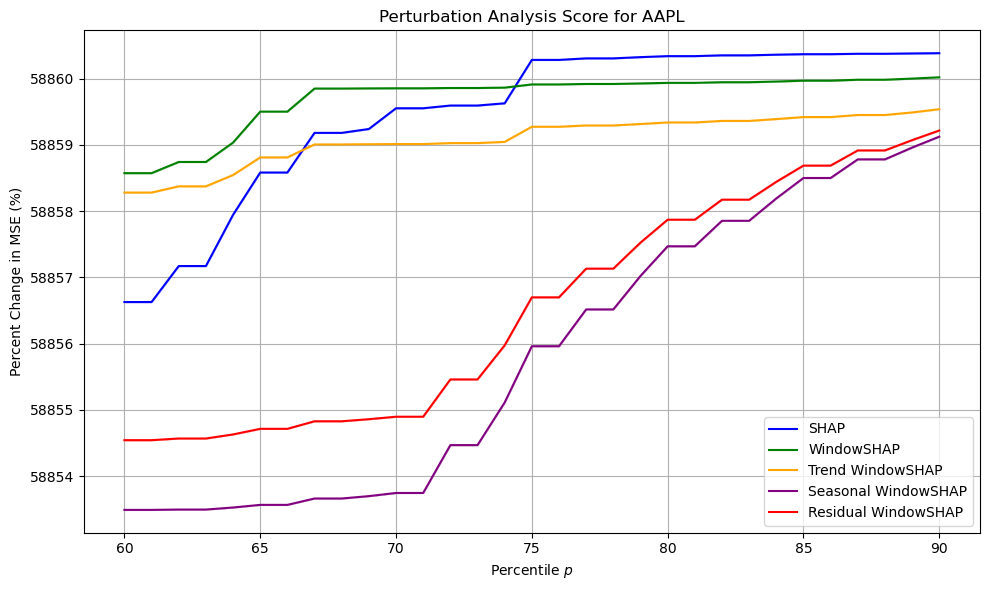

Plotting perturbation analysis for GOOGL...


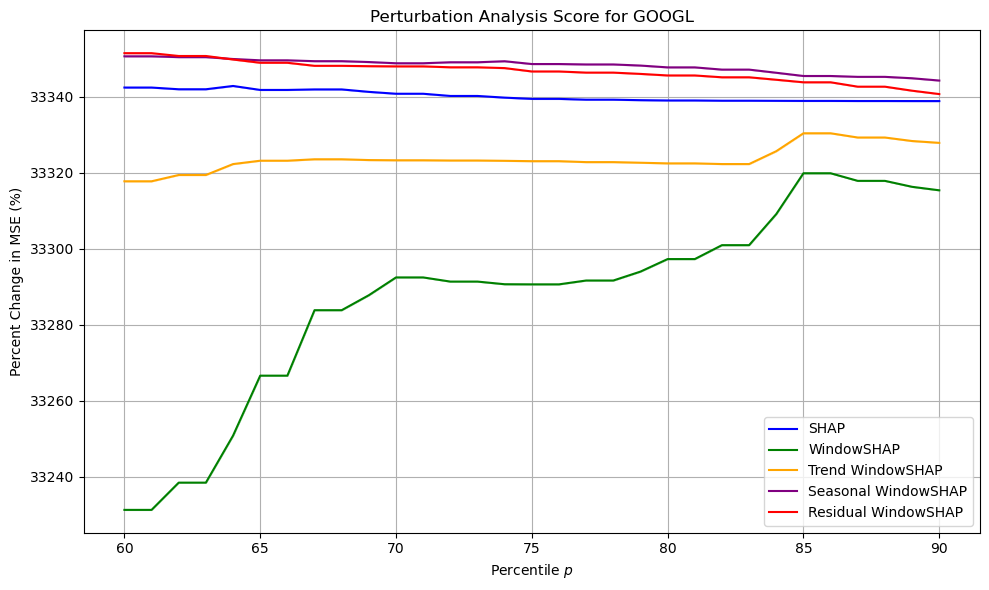

Plotting perturbation analysis for MSFT...


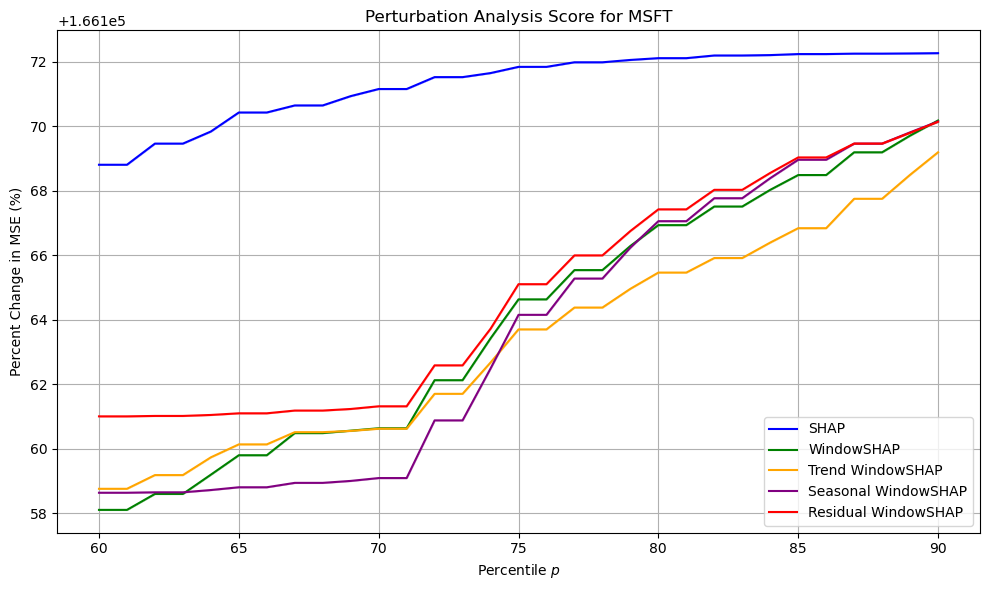

Plotting perturbation analysis for AMZN...


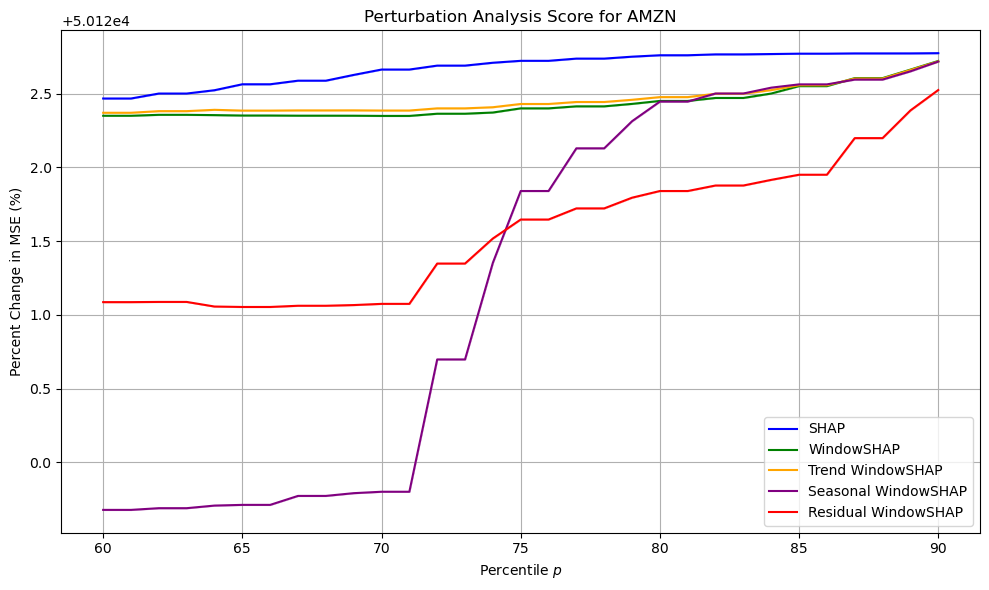

In [ ]:
def plot_perturbation_analysis(percentiles, shap_results, window_shap_results, decomp_shap_results, ticker, colors=None):
    plt.figure(figsize=(10, 6))

    def get_ticker_mean_std(results):
        scores = np.array(results)

        if scores.ndim == 0:
            raise ValueError("Input results are scalar. Expected array-like shape (num_runs, num_percentiles).")
        elif scores.ndim == 1:
            if len(scores) == len(percentiles):
                # Single run, already shaped correctly
                scores = scores[np.newaxis, :]
            else:
                raise ValueError(f"1D input length ({len(scores)}) does not match number of percentiles ({len(percentiles)}).")

        elif scores.ndim > 2:
            raise ValueError(f"Too many dimensions in scores: shape {scores.shape}")

        mean = np.mean(scores, axis=0)
        std = np.std(scores, axis=0)
        return mean, std

    
    if colors is None:
        colors = ['blue', 'green', 'orange', 'purple', 'red']

    # Plotting logic — moved outside of the colors conditional
    shap_mean, shap_std = get_ticker_mean_std(shap_results[ticker])
    win_mean, win_std = get_ticker_mean_std(window_shap_results[ticker])
    trend_mean, trend_std = get_ticker_mean_std(decomp_shap_results[ticker]['trend'])
    season_mean, season_std = get_ticker_mean_std(decomp_shap_results[ticker]['seasonal'])
    resid_mean, resid_std = get_ticker_mean_std(decomp_shap_results[ticker]['resid'])

    plt.plot(percentiles, shap_mean, label='SHAP', color=colors[0])
    plt.fill_between(percentiles, shap_mean - shap_std, shap_mean + shap_std, color=colors[0], alpha=0.2)

    plt.plot(percentiles, win_mean, label='WindowSHAP', color=colors[1])
    plt.fill_between(percentiles, win_mean - win_std, win_mean + win_std, color=colors[1], alpha=0.2)

    plt.plot(percentiles, trend_mean, label='Trend WindowSHAP', color=colors[2])
    plt.fill_between(percentiles, trend_mean - trend_std, trend_mean + trend_std, color=colors[2], alpha=0.2)

    plt.plot(percentiles, season_mean, label='Seasonal WindowSHAP', color=colors[3])
    plt.fill_between(percentiles, season_mean - season_std, season_mean + season_std, color=colors[3], alpha=0.2)

    plt.plot(percentiles, resid_mean, label='Residual WindowSHAP', color=colors[4])
    plt.fill_between(percentiles, resid_mean - resid_std, resid_mean + resid_std, color=colors[4], alpha=0.2)

    plt.title(f"Perturbation Analysis Score for {ticker}")
    plt.xlabel("Percentile $p$")
    plt.ylabel("Percent Change in MSE (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for ticker in tickers_list:
    print(f"Plotting perturbation analysis for {ticker}...")
    plot_perturbation_analysis(
        percentiles,
        shap_results,
        window_shap_results,
        decomp_shap_results,
        ticker=ticker
    )
